In [2]:
cd ..

/Users/mmt/Dropbox/Code/waterbot


In [3]:
import os
import glob
import json

import datetime as dt
import numpy as np
import pandas as pd

from waterbot import util

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

/Users/mmt/anaconda/envs/waterbot/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
MONTHS = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [6]:
reservoirs = json.load(open('reservoirs_all.json'))
    
dfs = []
for reservoir in reservoirs:
    station_id = reservoir['station_id']
    csvpath = 'data/historical_levels/{}.csv'.format(station_id)
    df = pd.read_csv(csvpath, parse_dates=['date'])
    df['station_id'] = station_id
    
#     df.loc[ 
#           (df['reservoir_storage'] > reservoir['capacity'] * 1.5)
#         | (df['reservoir_storage'] < reservoir['capacity'] * 0.01), 
#         'reservoir_storage'
#     ] = np.nan
    
#     df.fillna(
#         method='bfill',
#         inplace=True
#     )
    
    dfs.append(df)
#     print df.date.min()

In [7]:
dfs[0].date.iloc[0]

Timestamp('1990-01-01 00:00:00')

In [8]:
ALL_DATES = pd.Series( pd.date_range('1990-01-01', '2017-01-12', freq='D') )

# dates = dfs[1].date.tolist()
# for i, d in ALL_DATES.iteritems():
#     if d not in dates:
#         print d

In [9]:
filled_dfs = []
for df in dfs:

    to_fill = (
        df
        .drop('time', axis=1)
        .set_index('date')
        .reindex(ALL_DATES)
    )

    rmed = to_fill.rolling(20, min_periods=1, center=True).median()

    to_fill.loc[
          (to_fill.reservoir_storage < .9  * rmed.reservoir_storage)
        | (to_fill.reservoir_storage > 1.1 * rmed.reservoir_storage),
        'reservoir_storage'
    ] = np.nan

    station_id = to_fill[ to_fill.station_id.notnull() ].station_id.iloc[0]
    
    to_fill = to_fill.interpolate()
    to_fill.station_id = to_fill.station_id.fillna( station_id )
    to_fill.index.name = 'date'

    filled_dfs.append(to_fill.reset_index())
    
# rmed.reservoir_storage.plot(figsize=(20, 4))
# to_fill.reservoir_storage.plot(style='k.-', figsize=(20, 4))

cle whi lew wrs coy sha kes oro ant frd dav bul eng fol unv lon ich nat inv blb nhg cmn par don brd tul nml dnp hth chv exc buc hid mil snl pnf trm scc isb stp inp dnn cch pym cas prr


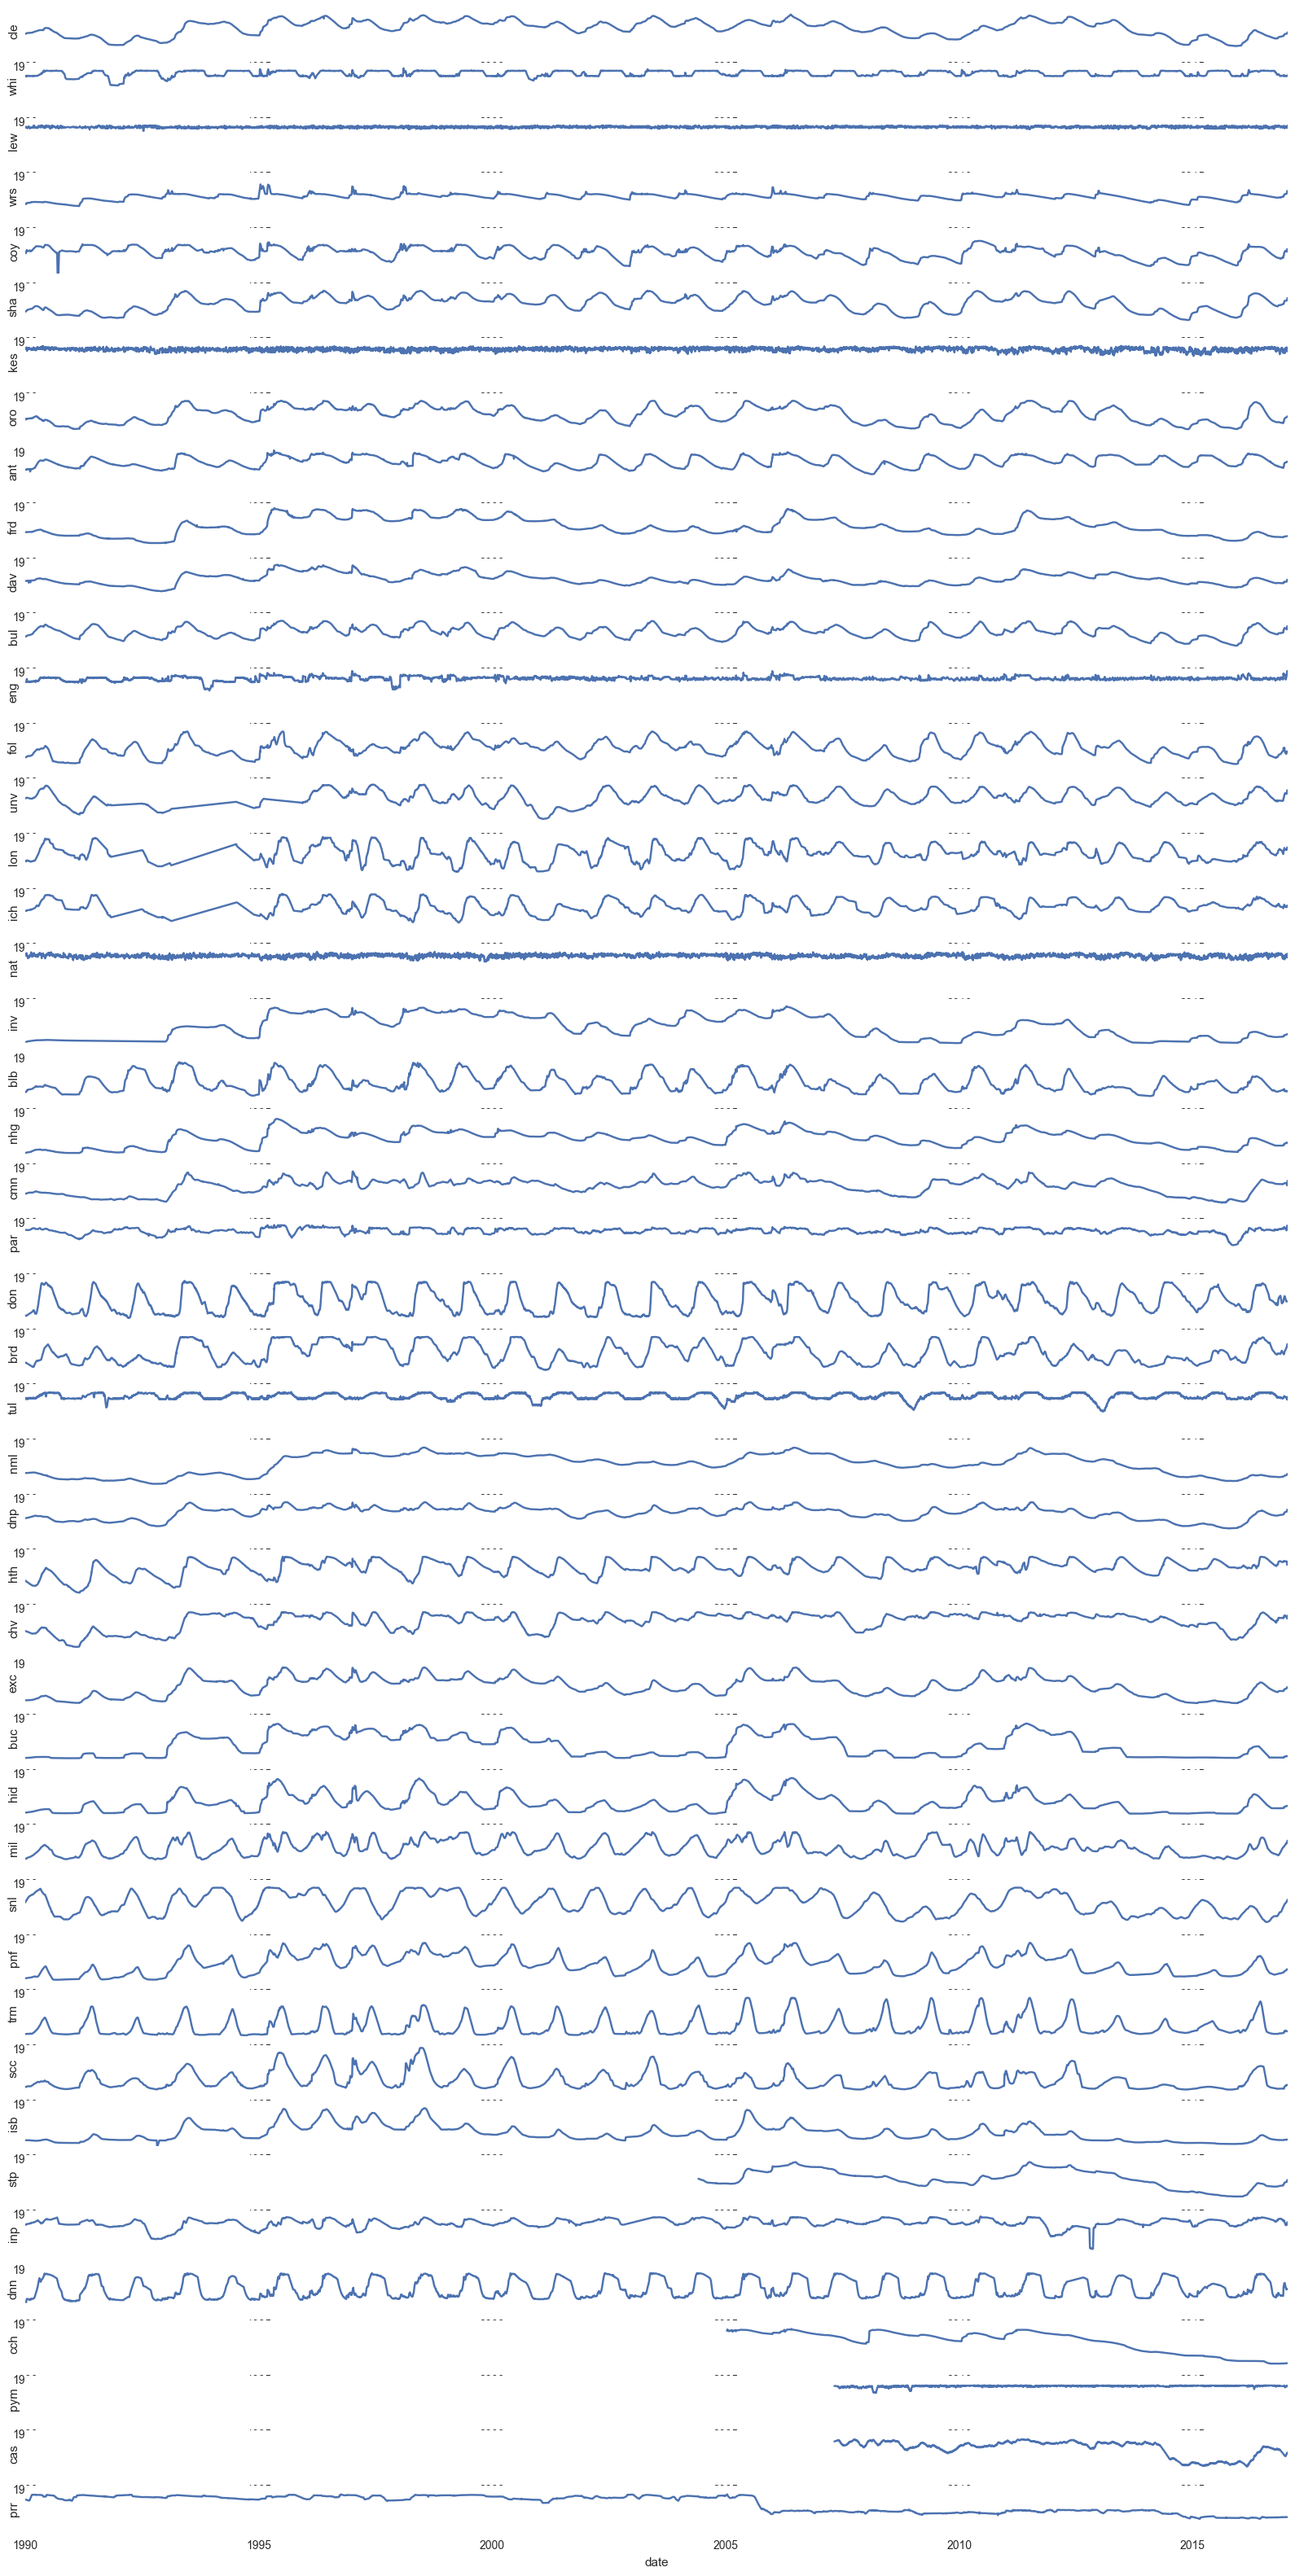

In [10]:
fig = plt.figure(figsize=(20, 40))

xaxis = None

for i, d in enumerate(filled_dfs):
    station_id = d.station_id.iloc[0]
    print station_id, 
    res = [r for r in reservoirs if r['station_id'] == station_id][0]
#     print res['station_id'], d.date.min(), d.date.max(), res['capacity']
    
    plt.subplot( len(dfs), 1, i+1 )
    d.set_index('date').reservoir_storage.plot()
    sns.despine(left=True, bottom=True)
    plt.ylabel(res['station_id'])
    plt.yticks([])
    if xaxis is None:
        xaxis = list(plt.axis()[:2])
#     else:
#         plt.axis(xaxis + list(plt.axis()[2:]) )
    plt.axis(xaxis + [0, res['capacity'] * 1.2] )

In [11]:
# filled_dfs[-1].set_index('date').reservoir_storage.plot()

In [12]:
dfc = pd.concat(dfs)
filled_dfc = pd.concat(filled_dfs)

dfc['day_of_year'] = dfc.date.apply(
    lambda d: d.timetuple().tm_yday
)

dfc.head()

,date,time,reservoir_storage,station_id,day_of_year
0,1990-01-01,0,1258733.0,cle,1
1,1990-01-02,0,1258207.0,cle,2
2,1990-01-03,0,1258102.0,cle,3
3,1990-01-04,0,1257891.0,cle,4
4,1990-01-05,0,1257470.0,cle,5


In [13]:
# (
#     dfc
#     [
#         (dfc.date < dt.date(2010, 1, 1))
#     ]
#     .plot.scatter(x='day_of_year', y='reservoir_storage', figsize=(18,12))
# )

# plt.axis( list(plt.axis()[:2]) + [0, 5e6])

In [14]:
df = (
    dfc
    .groupby('date')
    .agg({
        'reservoir_storage': 'sum',
        'station_id': 'count'
    })
    .reset_index()
)

df['day_of_year'] = df.date.apply(
    lambda d: d.timetuple().tm_yday
)

filled_df = (
    filled_dfc
    .groupby('date')
    .agg({
        'reservoir_storage': 'sum',
        'station_id': 'count'
    })
    .reset_index()
)

filled_df['day_of_year'] = filled_df.date.apply(
    lambda d: d.timetuple().tm_yday
)


In [15]:
df.head()

,date,reservoir_storage,station_id,day_of_year
0,1990-01-01,11270867.0,38,1
1,1990-01-02,8979852.0,34,2
2,1990-01-03,8970834.0,34,3
3,1990-01-04,8963870.0,34,4
4,1990-01-05,8958284.0,34,5


In [16]:
print df.date.min()
print df.date.max()

1990-01-01 00:00:00
2017-01-11 00:00:00


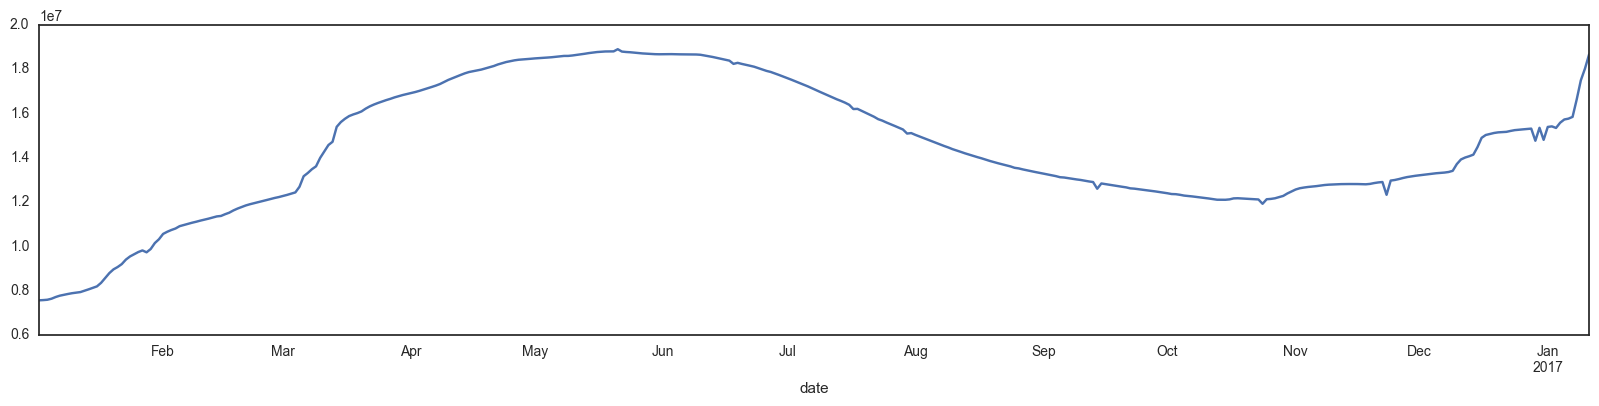

In [17]:
plt.figure(figsize=(20,4))
(
    df
    [ df.date > dt.date(2016, 1, 1 )]
    .set_index('date')
    .reservoir_storage
    .plot()
)

In [18]:
shades = (
    filled_df
    [
        (filled_df.date < dt.date(2010, 1, 1))
    ]
    .groupby('day_of_year')
    .reservoir_storage
    .agg({
        'lo': lambda x: np.percentile(x, 20),
        'mid': lambda x: np.percentile(x, 40),
        'hi': lambda x: np.percentile(x, 60),
        'median': 'median',
        'mean': 'mean'
    })
)

shades.head()

,lo,hi,median,mid,mean
day_of_year,,,,,
1,1.101145e+07,1.637933e+07,1.545758e+07,1.430847e+07,1.481233e+07
2,1.119764e+07,1.643855e+07,1.550637e+07,1.448294e+07,1.490746e+07
3,1.120180e+07,1.649051e+07,1.560116e+07,1.453572e+07,1.495749e+07
4,1.120594e+07,1.653959e+07,1.565241e+07,1.458365e+07,1.499912e+07
5,1.120499e+07,1.654882e+07,1.569500e+07,1.463061e+07,1.502477e+07


In [19]:
# fig = plt.figure(figsize=(12,4))

# (
#     df
#     [
#         (df.date >= dt.date(2016, 1, 1)) &
#         (df.date <  dt.date(2017, 2, 1))
#     ]
#     .set_index('day_of_year')
#     .reservoir_storage
#     .plot(color='black', linewidth=3)
# )

# shades['median'].plot(linestyle=':', color='blue')
# shades['mean'].plot(linestyle=':', color='green')

# plt.legend(['2016', '1990-2010 median', '1990-2010 mean'], loc=4)
# plt.axis( list(plt.axis()[:2]) + [0, plt.axis()[3]] )

# # plt.xticks(range(0, 350, 31), MONTHS)

In [20]:
# fig, ax = plt.subplots(1, figsize=(12,4))
# ax.fill_between(shades.index, df.reservoir_storage.quantile(.01), shades.lo, facecolor='red', alpha=0.5, linewidth=0)
# ax.fill_between(shades.index, shades.lo, shades.mid, facecolor='yellow', alpha=0.5, linewidth=0)
# ax.fill_between(shades.index, shades.mid, shades.hi, facecolor='#99ff00', alpha=0.5, linewidth=0)
# ax.fill_between(shades.index, shades.hi, df.reservoir_storage.quantile(.99), facecolor='green', alpha=0.5, linewidth=0)

# (
#     df
#     [
#           (df.date >= dt.date(2016, 1, 1)) 
#         & (df.date <  dt.date(2017, 2, 1))
#     ]
#     .set_index('day_of_year')
#     .reservoir_storage
#     .plot(color='black', linewidth=3)
# )

# plt.xticks(np.arange(0, 350, 30.41), MONTHS)
# plt.xlabel('month')
# plt.yticks([])
# # plt.axis( list(plt.axis()[:2]) + [ df.reservoir_storage.quantile(.01), df.reservoir_storage.quantile(.99) ] )

In [21]:
# mean_level = shades['mean']

# level_2016 = (
#     df
#     [
#         (df.date >= dt.date(2016, 1, 1)) &
#         (df.date <  dt.date(2017, 2, 1))
#     ]
#     .set_index('day_of_year')
#     .reservoir_storage
# )

# fig = plt.figure(figsize=(12, 4))

# plt.plot( [0, 365], [0, 0], 'k')
# plt.plot( (level_2016 - mean_level) / mean_level * 100, linewidth=3, color='darkred')

# plt.axis( [0, 365] + list(plt.axis()[2:]) )
# plt.legend(['mean', '2016'], loc=4)
# # plt.xticks(range(0, 350, 31), MONTHS)

# ytic = plt.yticks()[0]    
# plt.yticks(ytic, [str(yt)+'%' for yt in ytic])

([<matplotlib.axis.YTick at 0x126180e10>,
 <a list of 3 Text yticklabel objects>)

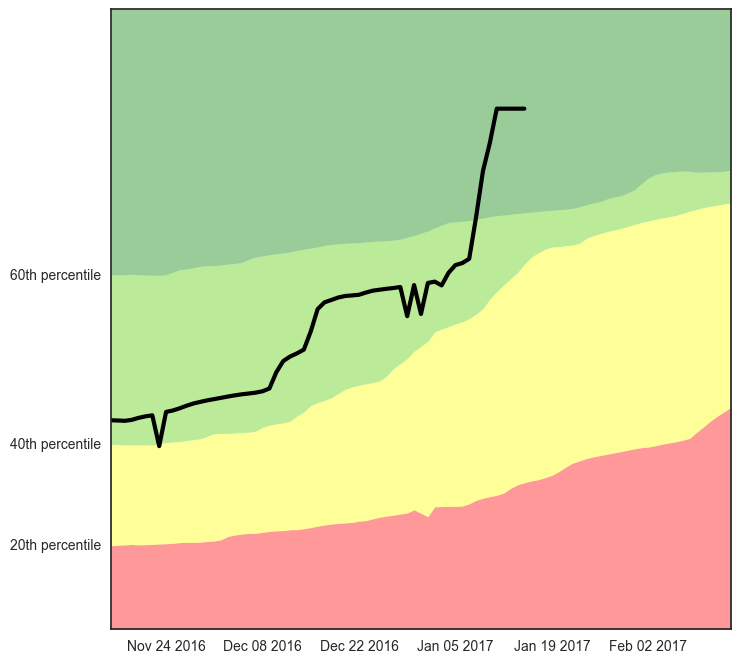

In [26]:
today = pd.Timestamp(dt.date.today())
first_day = today - dt.timedelta(days=60)
last_day  = today + dt.timedelta(days=30)

dates = pd.Series( pd.date_range(first_day, last_day, freq='D') )

plot_df = (
    df[ (df.date >= first_day) ]
    .set_index('date')
    .reindex(dates)
)

plot_df['day_of_year'] = pd.Series(plot_df.index, index=plot_df.index).apply(
    lambda d: d.timetuple().tm_yday
)

shades2 = (
    shades
    [shades.index <= 365]
    .copy()
)

plot_df = (
    pd.merge(
        plot_df,
        shades2,
        how='left',
        left_on='day_of_year',
        right_index=True
    )
    .interpolate()
)

fig, ax = plt.subplots(1, figsize=(8,8))

min_level = .85 * min( plot_df.reservoir_storage.min(), plot_df.lo.min() )
max_level = 1.1 * max( plot_df.reservoir_storage.max(), plot_df.lo.max() )

ax.fill_between(plot_df.index, min_level, plot_df.lo, facecolor='red', alpha=0.4, linewidth=0)
ax.fill_between(plot_df.index, plot_df.lo, plot_df.mid, facecolor='yellow', alpha=0.4, linewidth=0)
ax.fill_between(plot_df.index, plot_df.mid, plot_df.hi, facecolor='#55cc00', alpha=0.4, linewidth=0)
ax.fill_between(plot_df.index, plot_df.hi, max_level, facecolor='green', alpha=0.4, linewidth=0)

plt.plot(
    plot_df[ plot_df.index <= today ].index,
    plot_df[ plot_df.index <= today ].reservoir_storage,
    color='black', linewidth=3
)

# plt.plot(plot_df.loc[today].name, plot_df.loc[today].reservoir_storage, 'ko')

plt.ylim( min_level, max_level )

plt.yticks(
    plot_df.iloc[0][['lo', 'mid', 'hi']],
    ['{}th percentile'.format(y) for y in [20, 40, 60]]
)

# xticks = plt.xticks()
# for xt in xticks[1]:
#     print [d for d in dir(xt) if d[0] != '_']
#     print xt.get_text()
# plt.xticks(rotation=30)